In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [2]:
npix = 5

yy_s, yy_e = 2002, 2012
# yy_s, yy_e = 2002, 2023

year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
OBS_base = os.path.join(dir_base,'stations','data','Veneto','BACKUP_RAW')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
# names, lats, lons, yys, yye, nys, Ns, Cs, Ws = [], [], [], [], [], [], [], [], []

# for nn in range(len(INFO_pd)):
#     filename = f'{INFO_pd['File_Name'].values[nn]}.csv'
#     RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', filename), sep=',')
#     RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
#     ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
#     ny = (ee-ss)+1

#     RAIN_filtered = RAIN_pd[
#         (RAIN_pd['TIME'].dt.year >= yy_s) & 
#         (RAIN_pd['TIME'].dt.year <= yy_e)]

#     if len(RAIN_filtered) > 2000:
#         yys_new = pd.to_datetime(RAIN_filtered['TIME'].values[0]).year
#         yye_new = pd.to_datetime(RAIN_filtered['TIME'].values[-1]).year

#         names.append(INFO_pd['File_Name'].values[nn])
#         lats.append(INFO_pd['Lat'].values[nn])
#         lons.append(INFO_pd['Lon'].values[nn])
#         yys.append(yys_new)
#         yye.append(yye_new)
#         nys.append(ny)

# METADATA = pd.DataFrame({
#             'File_Name':names, 
#             'Lat':lats, 'Lon':lons, 
#             'YYS':yys, 'YYE':yye, 'NY':nys})

# print(f'Number of stations: {len(METADATA)}')

In [19]:
names, lats, lons, yys, yye, nys, elev, Ns, Cs, Ws = [], [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    RAIN_filtered = RAIN_pd[
        (RAIN_pd['TIME'].dt.year >= yy_s) & 
        (RAIN_pd['TIME'].dt.year <= yy_e)]

    if len(RAIN_filtered) > 2000:
        yys_new = pd.to_datetime(RAIN_filtered['TIME'].values[0]).year
        yye_new = pd.to_datetime(RAIN_filtered['TIME'].values[-1]).year

        RAIN_xr = xr.DataArray(RAIN_filtered['PRE'].values,
                            coords={'time':RAIN_filtered['TIME'].values}, 
                            dims=('time'))

        RAIN_pd = RAIN_filtered.dropna()

        names.append(INFO_pd['File_Name'].values[nn])
        lats.append(INFO_pd['Lat'].values[nn])
        lons.append(INFO_pd['Lon'].values[nn])
        yys.append(ss)
        yye.append(ee)
        nys.append(ny)
        elev.append(INFO_pd['Elv'].values[nn])

    else:
        pass

wa_pd = pd.DataFrame({'File_Name':names, 
                    'Lat':lats, 'Lon':lons, 
                    'YYS':yys, 'YYE':yye, 
                    'Elv':elev,'NY':nys})

wa_pd = wa_pd[(wa_pd['YYS']<=yy_s)&(wa_pd['YYE']>=yy_e)]
wa_pd = wa_pd.reset_index(inplace=False)

wa_pd

,index,File_Name,Lat,Lon,YYS,YYE,Elv,NY
0,0,002_FG_BS,45.895600,12.815000,1995,2022,21,28
1,1,003_BL_Ar,46.499984,11.876073,1984,2023,1642,40
2,2,003_FG_BS,45.918000,12.545000,1995,2022,22,28
3,3,004-264_NP_Be,46.164679,12.244708,1993,2023,379,31
4,4,008_FG_BS,45.805700,13.052600,1995,2022,5,28
...,...,...,...,...,...,...,...,...
204,227,346_NP_La,46.129873,12.318301,1992,2023,386,32
205,228,348_NP_Ro,46.190733,12.407890,1992,2023,1160,32
206,229,349_NP_Tr,45.663472,12.237917,1987,2015,13,29
207,230,350_NP_Va,45.862455,11.659233,1984,2023,148,40


In [25]:
names, lats, lons, Q10, Q20, Q50, Q100 = [], [], [], [], [], [], []
for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', filename), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    RAIN_filtered = RAIN_pd[
        (RAIN_pd['TIME'].dt.year >= yy_s) & 
        (RAIN_pd['TIME'].dt.year <= yy_e)]

    if len(RAIN_filtered) > 2000:
        RAIN_xr = xr.DataArray(
                    RAIN_filtered['PRE'].values,
                    coords={'time':RAIN_filtered['TIME'].values}, 
                    dims=('time'))

        NCW = ART_down.fit_yearly_weibull_update(RAIN_xr,1)
        N = NCW[:,0]
        C = NCW[:,1]
        W = NCW[:,2]

        Tr = [10, 20, 50, 100]
        Fi = 1 - 1/np.array(Tr)
        x0 = np.nanmean(C)
        TMP_Q, _ = ART_down.mev_quant(Fi, x0, N, C, W, thresh=1)

        names.append(wa_pd['File_Name'].values[nn])
        lats.append(wa_pd['Lat'].values[nn])
        lons.append(wa_pd['Lon'].values[nn])
        Q10.append(TMP_Q[0])
        Q20.append(TMP_Q[1])
        Q50.append(TMP_Q[2])
        Q100.append(TMP_Q[3])

    QUANTILES = pd.DataFrame({
                    'File_Name':names, 
                    'Lat':lats, 
                    'Lon':lons, 
                    'Q10':Q10,
                    'Q20':Q20,
                    'Q50':Q50,
                    'Q100':Q100})

mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - cha

In [30]:
QUANTILES

,File_Name,Lat,Lon,Q10,Q20,Q50,Q100
0,002_FG_BS,45.895600,12.815000,132.290433,152.627964,180.347157,202.182683
1,003_BL_Ar,46.499984,11.876073,95.258394,109.507756,128.772213,143.837386
2,003_FG_BS,45.918000,12.545000,366.890787,644.901216,1158.842673,1657.414058
3,004-264_NP_Be,46.164679,12.244708,127.319605,144.233849,166.887672,184.466450
4,008_FG_BS,45.805700,13.052600,143.334055,174.528528,222.718519,264.490148
...,...,...,...,...,...,...,...
204,346_NP_La,46.129873,12.318301,142.130558,164.422240,194.601108,218.265524
205,348_NP_Ro,46.190733,12.407890,168.028058,194.085554,229.373837,257.054423
206,349_NP_Tr,45.663472,12.237917,108.038470,126.109172,151.302540,171.510320
207,350_NP_Va,45.862455,11.659233,222.836286,260.436974,311.916473,352.562139


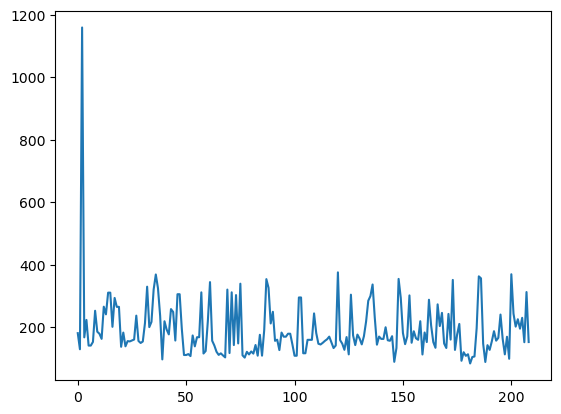

In [27]:
plt.plot(QUANTILES['Q50'].values)

In [31]:
# Remove station with strange data
wa_filter =QUANTILES[QUANTILES['Q50']<250]
wa_filter = wa_filter.reset_index(drop=True)
wa_filter.head(3)

,File_Name,Lat,Lon,Q10,Q20,Q50,Q100
0,002_FG_BS,45.895600,12.815000,132.290433,152.627964,180.347157,202.182683
1,003_BL_Ar,46.499984,11.876073,95.258394,109.507756,128.772213,143.837386
2,004-264_NP_Be,46.164679,12.244708,127.319605,144.233849,166.887672,184.466450


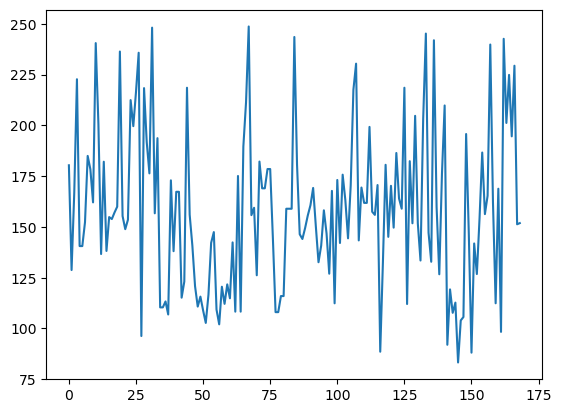

In [32]:
plt.plot(wa_filter['Q50'].values)

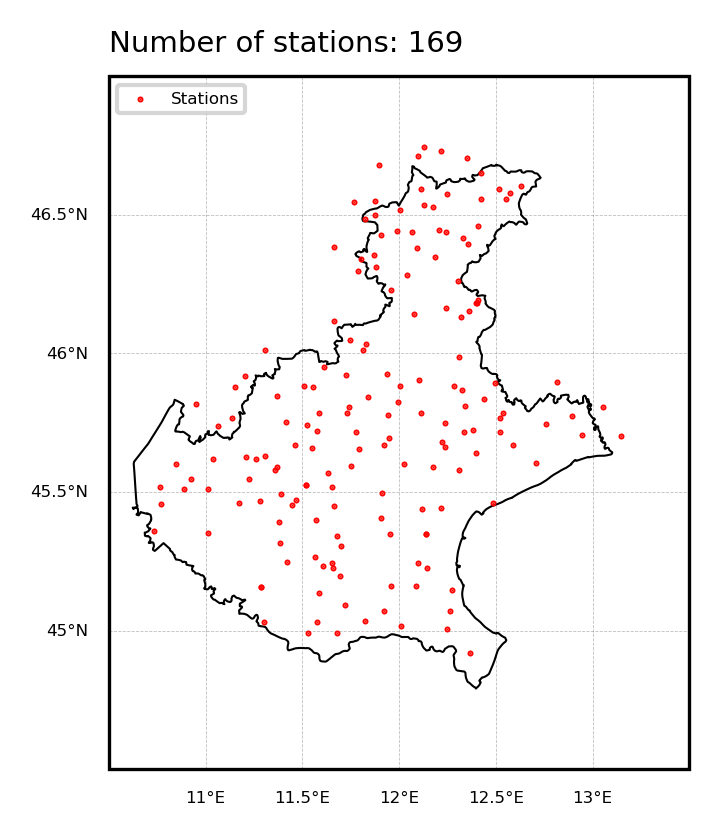

In [33]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

ax1.scatter(wa_filter['Lon'].values, wa_filter['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True

gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Number of stations: {len(wa_filter)}', loc='left', fontsize=7)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [34]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [35]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_IMERG, lat_IMERG  = np.meshgrid(DATA.lon.values, DATA.lat.values)
Tr = DATA['Tr'].values

Q_IMERG = DATA.Quantile.values
del DATA
Q_IMERG.shape

(4, 25, 30)

In [36]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_CMORPH, lat_CMORPH  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_CMORPH = DATA.Quantile.values
del DATA
Q_CMORPH.shape

(4, 10, 12)

In [37]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_MSWEP, lat_MSWEP  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_MSWEP = DATA.Quantile.values
del DATA
Q_MSWEP.shape

(4, 25, 30)

In [38]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_1dy_{yy_s}_{yy_e}_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_ERA5, lat_ERA5  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_ERA5 = DATA.Quantile.values
del DATA
Q_ERA5.shape

(4, 11, 13)

In [39]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_PERSIANN_1dy_{yy_s}_{yy_e}_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_PERSIANN, lat_PERSIANN  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_PERSIANN = DATA.Quantile.values
del DATA
Q_PERSIANN.shape

(4, 10, 12)

In [40]:
data_dir = os.path.join(data_base,'3_DOWN','VENETO_DOWN_SM2RAIN_1dy_2007_2022_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_SM2RAIN, lat_SM2RAIN  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_SM2RAIN = DATA.Quantile.values
# del DATA
Q_SM2RAIN.shape

(4, 26, 31)

In [41]:
# Tr_index, Q_index = 0, 'Q10'
# Tr_index, Q_index = 1, 'Q20'
Tr_index, Q_index = 2, 'Q50'
# Tr_index, Q_index = 3, 'Q100'

colors = ['royalblue','r', 'g', 'c', 'y', 'purple']

In [42]:
E_IMERG, E_CMORPH, E_MSWEP, E_ERA5, E_PERSIANN, E_SM2RAIN = [], [], [], [], [], []
ESEMBLE = []

for nn in range(len(wa_filter)):
    Q_OBS = wa_filter[Q_index][nn]
    lat_obs = wa_filter['Lat'][nn]
    lon_obs = wa_filter['Lon'][nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_val = Q_IMERG[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (IMERG_val - Q_OBS)/Q_OBS
    E_IMERG.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    CMORPH_val = Q_CMORPH[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (CMORPH_val - Q_OBS)/Q_OBS
    E_CMORPH.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    MSWEP_val = Q_MSWEP[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (MSWEP_val - Q_OBS)/Q_OBS
    E_MSWEP.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    ERA5_val = Q_ERA5[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (ERA5_val - Q_OBS)/Q_OBS
    E_ERA5.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_PERSIANN, lon_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_val = Q_PERSIANN[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (PERSIANN_val - Q_OBS)/Q_OBS
    E_PERSIANN.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    SM2RAIN_val = Q_SM2RAIN[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (SM2RAIN_val - Q_OBS)/Q_OBS
    E_SM2RAIN.append(float(ERROR_))

    SAT_BET_mean = np.nanmean(
                        [IMERG_val,
                        CMORPH_val,
                        MSWEP_val,
                        ERA5_val]
                        )
    ESEMBLE_ = (SAT_BET_mean - Q_OBS)/Q_OBS
    ESEMBLE.append(ESEMBLE_)


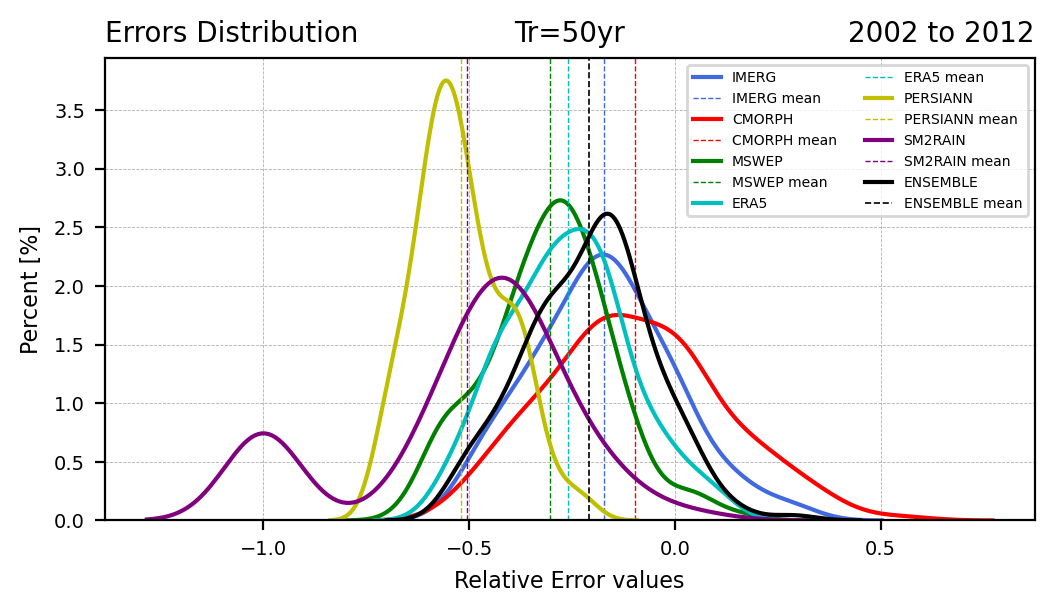

In [43]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(E_IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
ax1.axvline(np.nanmean(E_IMERG), color=colors[0], linestyle='--', linewidth=0.5, label='IMERG mean')

sns.kdeplot(E_CMORPH,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
ax1.axvline(np.nanmean(E_CMORPH), color=colors[1], linestyle='--', linewidth=0.5, label='CMORPH mean')

sns.kdeplot(E_MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
ax1.axvline(np.nanmean(E_MSWEP), color=colors[2], linestyle='--', linewidth=0.5, label='MSWEP mean')

sns.kdeplot(E_ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
ax1.axvline(np.nanmean(E_ERA5), color=colors[3], linestyle='--', linewidth=0.5, label='ERA5 mean')

sns.kdeplot(E_PERSIANN,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
ax1.axvline(np.nanmean(E_PERSIANN), color=colors[4], linestyle='--', linewidth=0.5, label='PERSIANN mean')

sns.kdeplot(E_SM2RAIN,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAIN')
ax1.axvline(np.nanmean(E_SM2RAIN), color=colors[5], linestyle='--', linewidth=0.5, label='SM2RAIN mean')

sns.kdeplot(ESEMBLE,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.nanmean(ESEMBLE), color='k', linestyle='--', linewidth=0.6, label='ENSEMBLE mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Errors Distribution', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

# =========================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

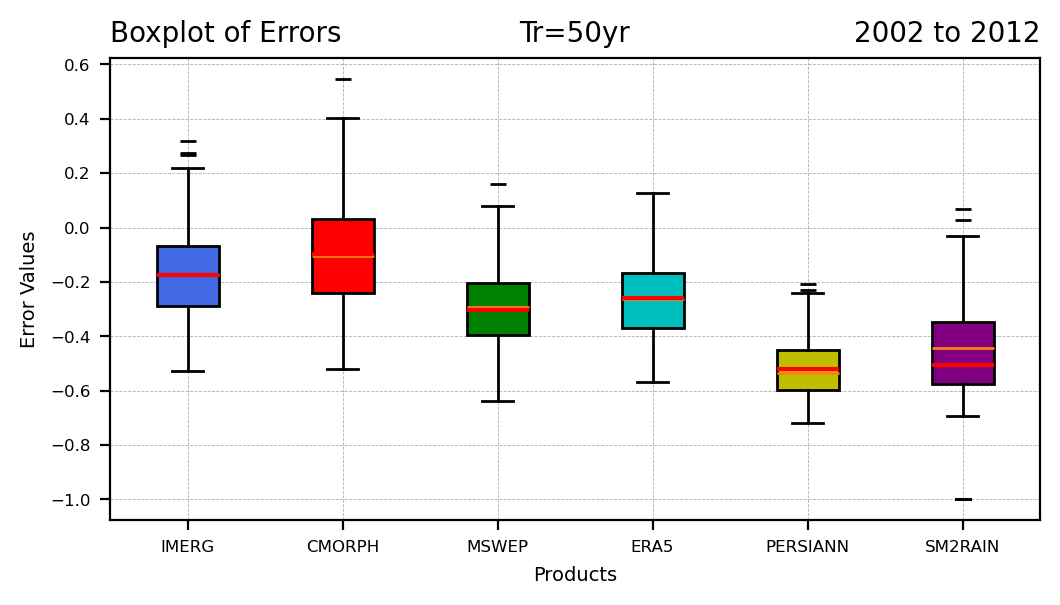

In [44]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

boxes = []
medians = []
mean = []
fliers = []

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

box = ax1.boxplot(E_IMERG,positions=[0],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[0],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(E_CMORPH,positions=[1],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[1],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(E_MSWEP,positions=[2],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[2],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(E_ERA5,positions=[3],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[3],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(E_PERSIANN,positions=[4],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[4],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_SM2RAIN)[~np.isnan(E_SM2RAIN)],positions=[5],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[5],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels(['IMERG','CMORPH','MSWEP','ERA5','PERSIANN','SM2RAIN'])
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlabel('Products',fontsize=7)
ax1.set_ylabel('Error Values',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('Boxplot of Errors', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [45]:
E_IMERG_M = np.ones_like(Q_IMERG[0,:,:])*np.nan
E_CMORPH_M = np.ones_like(Q_CMORPH[0,:,:])*np.nan
E_MSWEP_M = np.ones_like(Q_MSWEP[0,:,:])*np.nan
E_ERA5_M = np.ones_like(Q_ERA5[0,:,:])*np.nan
E_PERSIANN_M = np.ones_like(Q_PERSIANN[0,:,:])*np.nan
E_SM2RAIN_M = np.ones_like(Q_SM2RAIN[0,:,:])*np.nan

for nn in range(len(wa_filter)):
    Q_OBS = wa_filter[Q_index][nn]
    lat_obs = wa_filter['Lat'][nn]
    lon_obs = wa_filter['Lon'][nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_IMERG_M[min_index[0],min_index[1]] = 100*(Q_IMERG[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_CMORPH_M[min_index[0],min_index[1]] = 100*(Q_CMORPH[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_MSWEP_M[min_index[0],min_index[1]] = 100*(Q_MSWEP[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_ERA5_M[min_index[0],min_index[1]] = 100*(Q_ERA5[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_PERSIANN, lon_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_PERSIANN_M[min_index[0],min_index[1]] = 100*(Q_PERSIANN[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_SM2RAIN_M[min_index[0],min_index[1]] = 100*(Q_SM2RAIN[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

In [46]:
products = ['CMORPH', 'ERA5', 'IMERG', 'PERSIANN', 'MSWEP', 'SM2RAIN']
letter = ['(a)','(d)', '(b)', '(e)', '(c)', '(f)']

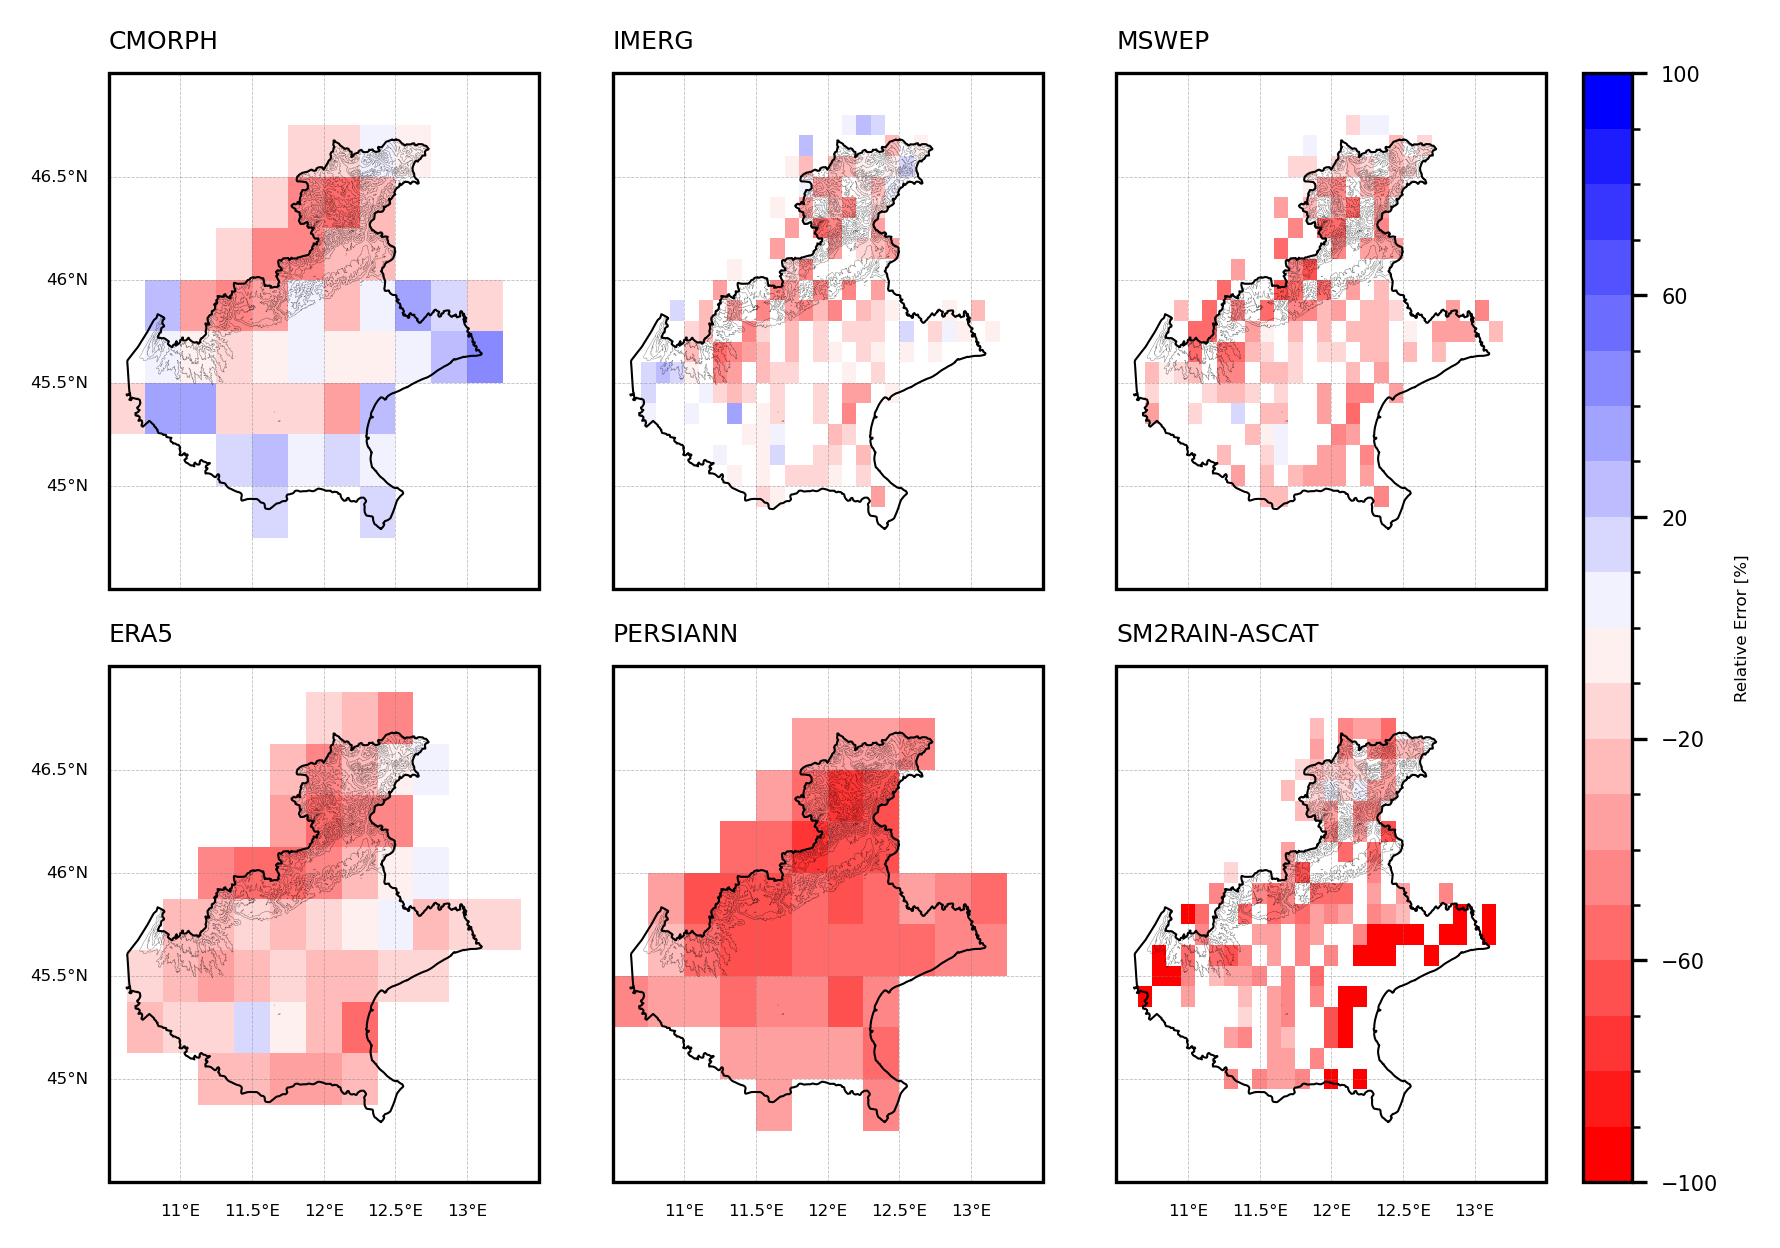

In [47]:
# levels = np.arange(-1.0,1.2,0.2)
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# ticks = np.arange(-1,1.4,0.4)

levels = np.arange(-100,110,10)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
ticks = np.arange(-100,140,40)

cmap = plt.cm.Spectral_r
cmap = plt.cm.bwr_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
pos = 0
count = 1
for ncol in range(3):
    for nrow in range(2):
        ax_name = f"ax{count}"
        globals()[ax_name] = plt.subplot(gs[nrow, ncol], projection=proj)
        globals()[ax_name].set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        VENETO.plot(facecolor='None', ax=globals()[ax_name], linewidth=0.5, zorder=10)
        DEM.plot(facecolor='None', ax=globals()[ax_name], zorder=10, linewidth=0.1, color='k', alpha=0.5)

        a1 = globals()[ax_name].pcolormesh(
                                    globals()[f"lon_{products[pos]}"], 
                                    globals()[f"lat_{products[pos]}"], 
                                    globals()[f"E_{products[pos]}_M"], 
                                    cmap=cmap,norm=norm)

        gl = globals()[ax_name].gridlines(crs=proj,draw_labels=False,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
        if ncol == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False
        if nrow == 0:
            gl.bottom_labels = False
        else:
            gl.bottom_labels = True
        gl.xlabel_style = {'size': 4, 'color': 'k'}
        gl.ylabel_style = {'size': 4, 'color': 'k'}

        # globals()[ax_name].set_title(f"{letter[pos]} {products[pos]}", fontsize=6, loc='left')
        
        if pos ==5:
            globals()[ax_name].set_title(f"{products[pos]}-ASCAT", fontsize=6, loc='left')
        else:
            globals()[ax_name].set_title(f"{products[pos]}", fontsize=6, loc='left')
        
        # cbar = plt.colorbar(a1, ticks=ticks, fraction=0.053)
        # cbar.set_label('Relative Error [%]',fontsize=4)
        # cbar.ax.tick_params(labelsize=4)

        count += 1
        pos += 1
# ==============================================================================
# ax1.set_title(f'Relative Error', fontsize=6, loc='right')
cbar_ax = fig.add_axes([0.9, 0.11, 0.025, 0.77])#0.91
cbar = plt.colorbar(a1, cax=cbar_ax, ticks= ticks, orientation='vertical')
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=5)

# ==============================================================================
plt.subplots_adjust(wspace=0, hspace=0.15)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [48]:
Q_IMERG_list = []
Q_CMORPH_list = []
Q_MSWEP_list = []
Q_ERA5_list = []
Q_PERSIANN_list = []
Q_SM2RAIN_list = []
for nn in range(len(wa_filter)):
    lat_obs = wa_filter['Lat'][nn]
    lon_obs = wa_filter['Lon'][nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_IMERG_list.append(float(Q_IMERG[Tr_index,min_index[0],min_index[1]]))
    
    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_CMORPH_list.append(Q_CMORPH[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_MSWEP_list.append(Q_MSWEP[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_ERA5_list.append(Q_ERA5[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_PERSIANN, lon_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_PERSIANN_list.append(Q_PERSIANN[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_SM2RAIN_list.append(Q_SM2RAIN[Tr_index,min_index[0],min_index[1]])

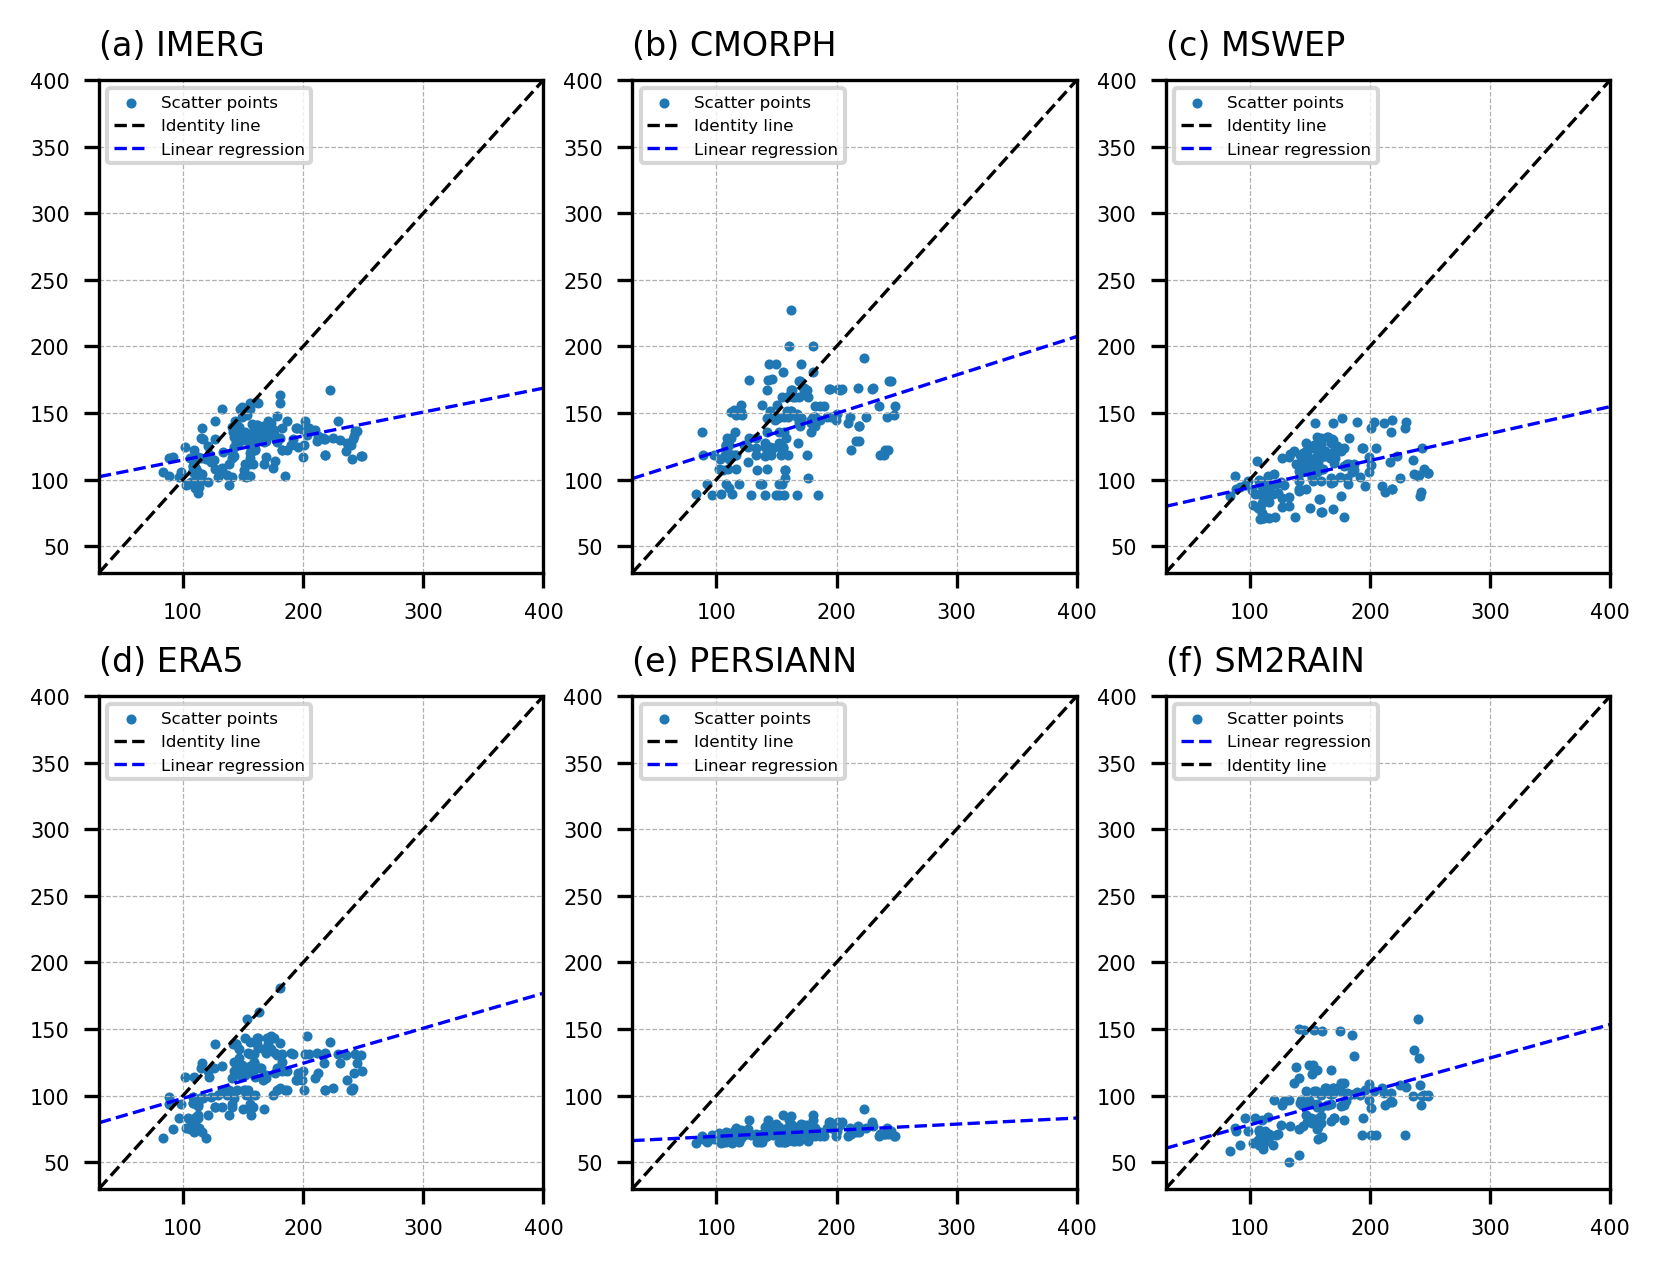

In [49]:
lmin, lmax = 30, 400

xx = np.arange(lmin,lmax+10,10)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_IMERG_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_IMERG_list)])
ax1.scatter(wa_filter['Q50'], Q_IMERG_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(wa_filter['Q50'], Q_IMERG_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERG', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_CMORPH_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_CMORPH_list)])
ax1.scatter(wa_filter['Q50'], Q_CMORPH_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(wa_filter['Q50'], Q_CMORPH_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPH', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_MSWEP_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_MSWEP_list)])
ax1.scatter(wa_filter['Q50'], Q_MSWEP_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(wa_filter['Q50'], Q_MSWEP_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_ERA5_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_ERA5_list)])
ax1.scatter(wa_filter['Q50'], Q_ERA5_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(wa_filter['Q50'], Q_ERA5_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_PERSIANN_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_PERSIANN_list)])
ax1.scatter(wa_filter['Q50'], Q_PERSIANN_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(wa_filter['Q50'], Q_PERSIANN_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) PERSIANN', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
max_val = np.max([
                np.nanmax(wa_filter['Q50']),
                np.nanmax(Q_SM2RAIN_list)])
min_val = np.min([
                np.nanmin(wa_filter['Q50']),
                np.nanmin(Q_SM2RAIN_list)])
a = np.array(wa_filter['Q50'])[np.array(Q_SM2RAIN_list)!=0]
b = np.array(Q_SM2RAIN_list)[np.array(Q_SM2RAIN_list)!=0]
ax1.scatter(a, b, s=2, label='Scatter points')
slope, intercept, _, _, _ = stats.linregress(a[~np.isnan(b)], b[~np.isnan(b)])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.set_title('(f) SM2RAIN', fontsize=8, loc='left')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

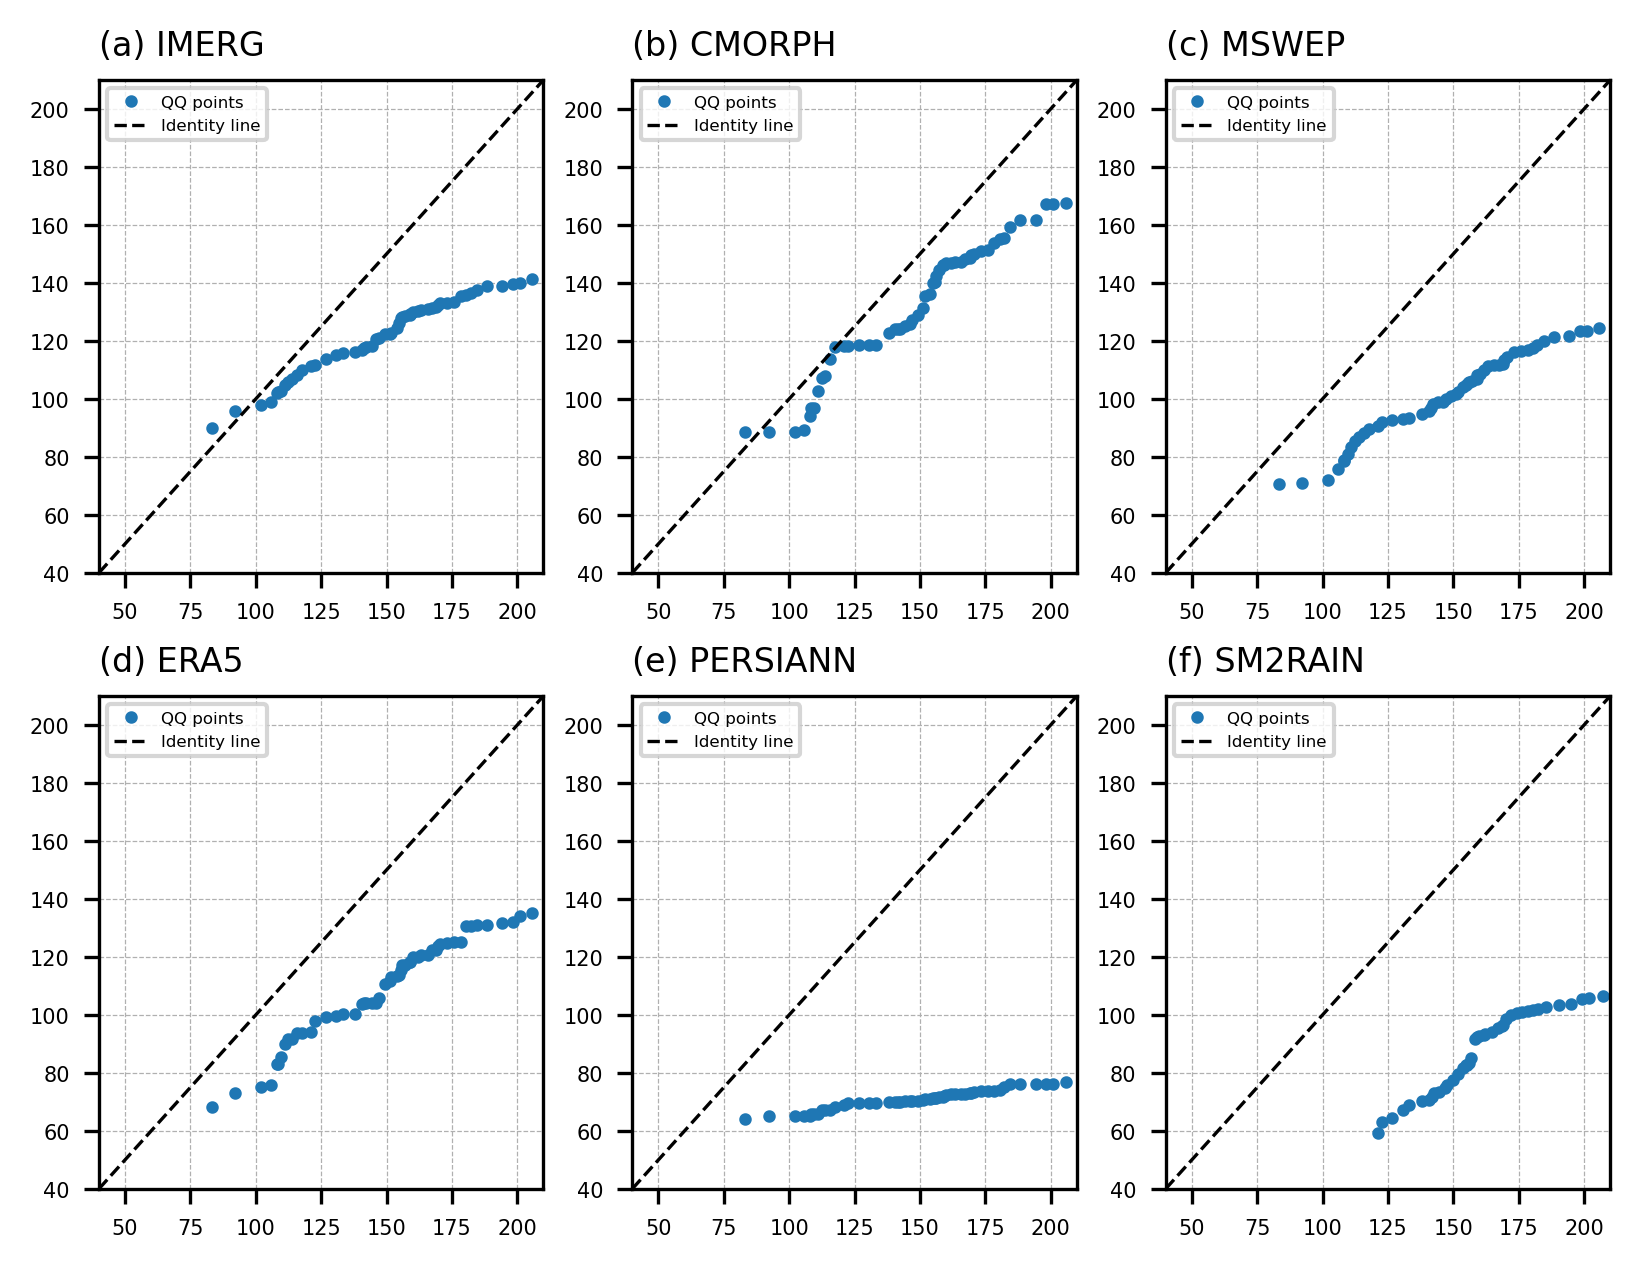

In [28]:
percs = np.linspace(0,100,61)
x = np.linspace(40,220)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])

qn_a = np.percentile(wa_filter['Q50'], percs)
qn_b = np.percentile(Q_IMERG_list, percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERG', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])

qn_a = np.percentile(wa_filter['Q50'], percs)
qn_b = np.percentile(Q_CMORPH_list, percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPH', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])

qn_a = np.percentile(wa_filter['Q50'], percs)
qn_b = np.percentile(Q_MSWEP_list, percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])

qn_a = np.percentile(wa_filter['Q50'], percs)
qn_b = np.percentile(Q_ERA5_list, percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])

qn_a = np.percentile(wa_filter['Q50'], percs)
qn_b = np.percentile(Q_PERSIANN_list, percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) PERSIANN', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])

qn_a = np.percentile(np.array(wa_filter['Q50'])[~np.isnan(np.array(Q_SM2RAIN_list))], percs)
qn_b = np.percentile(np.array(Q_SM2RAIN_list)[~np.isnan(np.array(Q_SM2RAIN_list))], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(f) SM2RAIN', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(40,210)
ax1.set_xlim(40,210)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)